In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model

,Time,Time (s),Current (A),Potential vs Li/Li$^+$ (V)
0,5449.279046,0.000000,1.054993e-04,3.897400
1,5449.379046,0.100000,7.540894e-05,3.896790
2,5449.479046,0.200000,6.064148e-05,3.897095
3,5449.579046,0.300000,5.108948e-05,3.897400
4,5449.679046,0.400000,4.499512e-05,3.897400
...,...,...,...,...
17995,7248.779042,1799.499995,-5.310059e-08,3.896484
17996,7248.879042,1799.599995,6.906128e-07,3.897095
17997,7248.979042,1799.699995,6.054687e-07,3.897095
17998,7249.079042,1799.799995,3.942871e-07,3.896790


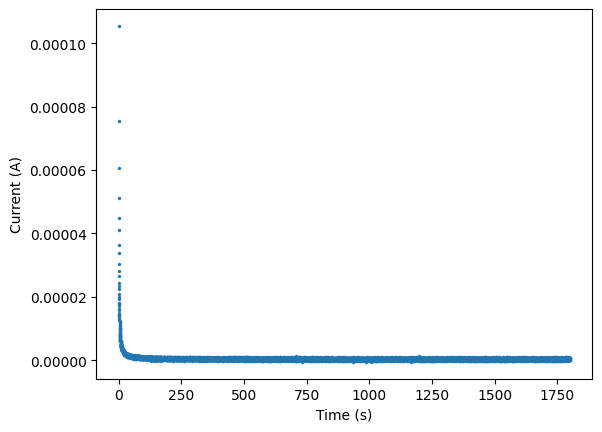

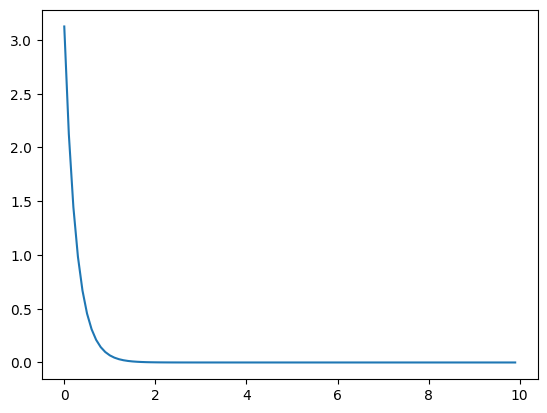

In [22]:
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\LESK32\PLSA Pt\PITT'
files = [os.path.join(path, i) for i in os.listdir(path)]
area = np.pi * 0.5**2
F = 96485 # C/mol

col = ['Time', 'Time (s)', 'Current (A)', 'Potential vs Li/Li$^+$ (V)'] # 'Current Density (µA/cm$^2$)'
df = pd.read_csv(files[3], sep = ';', skiprows = 1, names = col)#, skipfooter=17800)
# df[col[2]] = df[col[2]] * 1e6 / area

#Model
def pitt(t, delta_q, D, L, i_b): #t, S, C, D, L ):
    # return ((2 *F * S * C * D)/L) * np.exp(-(np.pi**2 * D * t) / (4 * L ** 2))
    return (2 * delta_q * D / L ** 2) * np.exp(-(np.pi ** 2 * D * t / (4 * L** 2))) + i_b

gmodel = Model(pitt)

params = gmodel.make_params() # param5['r_s'].set(value = 1e10, min = 0)
# params['S'].set(value = area, vary = False)
# params['L'].set(value = 80e-7, vary = False) #, max = 8e-6)
# params['D'].set(value = 1e-10, min = 1e-14, max = 1e-6)
# params['C'].set(value = 1e-5, min = 0, max = 1)

# fit = gmodel.fit(df[col[2]], params, t = df[col[1]])
# print(fit.fit_report())

params['D'].set(value = 1e-10, min = 1e-20, max = 1e-5)
params['L'].set(value = 80e-7, vary = False)
params['delta_q'].set(value = 0.1, min = 1e-22)
params['i_b'].set(value = 3e-7, min = 0, max = 1e-6)

# fit = gmodel.fit(df[col[2]], params, t = df[col[1]])
# print(fit.fit_report())


# Plot
fig, ax = plt.subplots(dpi = 100)
sns.scatterplot(data = df, x = col[1], y = col[2], edgecolor = None, s = 5)
# plt.plot(df[col[1]], fit.best_fit, color = 'k')


x = np.arange(0,10,0.1)
y = pitt(x, 1, 1e-10, 80e-7, 3e-7)
fig, ax = plt.subplots(dpi = 100)
plt.plot(x, y)

df